# CSE 572: Lab 16

In this lab, you will practice measuring cluster validity with unsupervised metrics and applying clustering to a real world problem.

To execute and make changes to this notebook, click File > Save a copy to save your own version in your Google Drive or Github. Read the step-by-step instructions below carefully. To execute the code, click on each cell below and press the SHIFT-ENTER keys simultaneously or by clicking the Play button. 

When you finish executing all code/exercises, save your notebook then download a copy (.ipynb file). Submit the following **three** things:
1. a link to your Colab notebook,
2. the .ipynb file, and
3. a pdf of the executed notebook on Canvas.

To generate a pdf of the notebook, click File > Print > Save as PDF.

## Scenario 🎃

You have been hired by Costco to design the assorted Halloween candy mix bags that they will sell this Halloween. Since people tend to have different candy preferences (e.g., chocolate-y, fruity, sugar-y, etc.), they want you to create the mixes so there are similar types of candies in each bag and that you maximize the diversity across bags.

Luckily, you have access to a [dataset collected by FiveThirtyEight](https://fivethirtyeight.com/videos/the-ultimate-halloween-candy-power-ranking/) that aggregates the feedback from more than 269,000 votes were collected from 8,371 different IP addresses. Data were collected through a survey where participants were shown two fun-sized candies and asked to click on the one they would prefer to receive. The survey results were aggregated into a table with one row per candy type. The attributes for each candy type describe the candy flavor profile (e.g., does it have chocolate? does it have caramel? is it a hard or soft candy?), the sugar percentage, the price percentage, and the win percentage (indicating the percentage of the time that the candy won in the survey matchup). 

Your goal is to use clustering algorithms to determine how the candies should be grouped into assorted bags (including the number of bags to create). You will create multiple clusterings and use cluster validity measures to evaluate which clustering is best. You will use your final choice of clustering to determine the groups of candy to create for each of the candy mix bags.

### Load the dataset

In [70]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/r466lc6rgojrhdzdqchnfhxqvifz7m')

In [71]:
df.sample(10)

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
62,Nestle Smarties,1,0,0,0,0,0,0,0,1,0.267,0.976,37.887188
24,HersheyÕs Milk Chocolate,1,0,0,0,0,0,0,1,0,0.430,0.918,56.490501
35,Milk Duds,1,0,1,0,0,0,0,0,1,0.302,0.511,55.064072
71,Sugar Daddy,0,0,1,0,0,0,0,0,0,0.418,0.325,32.230995
46,Payday,0,0,0,1,1,0,0,1,0,0.465,0.767,46.296597
45,Now & Later,0,1,0,0,0,0,0,0,1,0.220,0.325,39.446800
10,Charleston Chew,1,0,0,0,1,0,0,1,0,0.604,0.511,38.975037
33,M&MÕs,1,0,0,0,0,0,0,0,1,0.825,0.651,66.574585
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
34,Mike & Ike,0,1,0,0,0,0,0,0,1,0.872,0.325,46.411716


We will create a separate numpy array that contains only the columns that we want to use for clustering (i.e., excludes the `competitorname` and `winpercent` columns).

In [72]:
data = df.to_numpy()[:,1:-1]

Before we start applying and evaluating our clustering algorithms, we might first want to try to visualize the data to see what sort of structure exists. One way to visualize our data is using a scatter plot of a pair of features, e.g., sugarpercent and pricepercent.

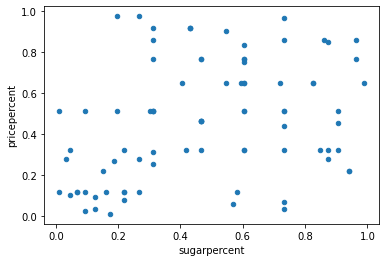

In [73]:
df.plot.scatter('sugarpercent', 'pricepercent')

Another way to visualize our 11-dimensional dataset is by reducing the dimensionality to 2 using PCA, then plotting the scatter plot of the first two PCs. 

Do this in the cell below.

Text(0, 0.5, 'PC2')

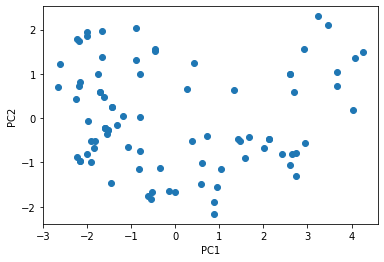

In [74]:
# YOUR CODE HERE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA(n_components=2).fit(scaled_data)
df_pca = pca.transform(scaled_data)

plt.scatter(df_pca[:,0], df_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
# df_pca = pd.DataFrame(data_pca, columns = ['PC1','PC2'])

## Cluster the data

We will evaluate agglomerative clustering and K-means clustering for our dataset. First, we'll use the scipy library used in Lab 15 to cluster the data using the complete link (MAX) agglomerative clustering algorithm and visualize the resulting dendrogram. This dendrogram may also be useful to visualize the dataset if the clusters respond to meaningful taxonomies.

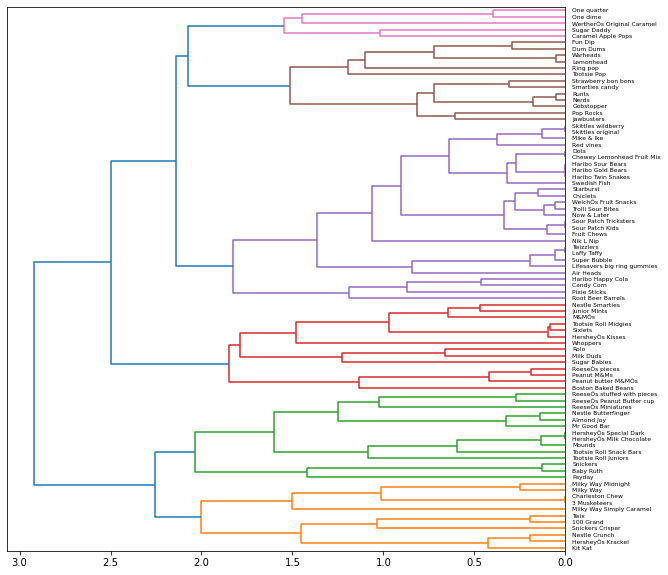

In [75]:
from scipy.cluster import hierarchy

fig, ax = plt.subplots(ncols=1, figsize=(10,10))
Z = hierarchy.linkage(data, 'complete')
dn = hierarchy.dendrogram(Z, labels=df['competitorname'].tolist(), orientation='left', ax=ax)

Since we will use Scikit-learn for K-means clustering, we'll recreate the agglomerative clustering using Scikit-learn too below. Recall that we can create a partitional clustering from a hierarchical clustering by cutting the dendrogram at a particular level. If we cut the dendrogram at about 2.0, our clustering would have 6 clusters. We will use this number of clusters for our Scikit-learn implementation below.

In [76]:
from sklearn.cluster import AgglomerativeClustering

agglom = AgglomerativeClustering(n_clusters=6, linkage='complete').fit(data)

# Add resulting cluster labels to dataframe
df['Agglom clusters'] = agglom.labels_

We will also evaluate clusterings produced by K-means. First, we need to decide how many clusters to use. In the cell below, plot the SSE as a function of number of clusters for up to 15 clusters. Set the random seed to 0 for K-means.

Text(0, 0.5, 'SSE')

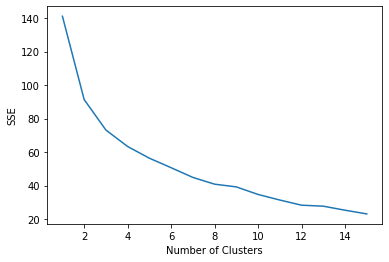

In [77]:
# YOUR CODE HERE
from sklearn.cluster import KMeans

num_clusters = range(1, 16)
sse = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

plt.plot(num_clusters, sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

Looking at the plot above, it looks like there is a bend in the curve around 4 clusters. However, we might also think that 6 clusters might be a good choice because this is what we found using agglomerative clustering. So let's try both!

In the cell below, cluster the data using K-means with 4 clusters and 6 clusters. Then add the resulting cluster labels as new columns in our dataframe `df` called `KM4 clusters` and `KM6 clusters`.  Set the random state to 0 for both models.

In [78]:
# YOUR CODE HERE
km4 = KMeans(n_clusters=4, random_state=0)
km6 = KMeans(n_clusters=6, random_state=0)

km4.fit(data)
km6.fit(data)

df['KM4 clusters'] = km4.labels_
df['KM6 clusters'] = km6.labels_

### Cluster validity

Now we have 3 different clusterings that we need to evaluate to determine which gives the best candy groupings to recommend for Costco to create their bags. First, let's visualize the three different clusterings in our PCA visualization of the data.

Text(0.5, 1.0, 'Agglomerative (k=6)')

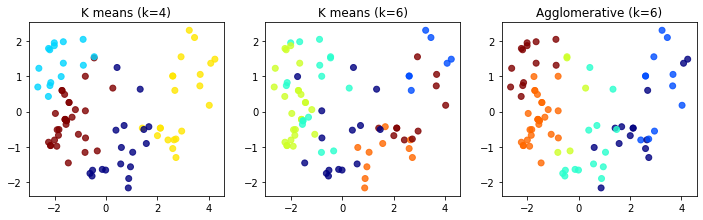

In [79]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
fig.tight_layout()

ax[0].scatter(df_pca[:,0], df_pca[:,1], alpha=0.8, c=df['KM4 clusters'], cmap='jet')
ax[0].set_title('K means (k=4)')

ax[1].scatter(df_pca[:,0], df_pca[:,1], alpha=0.8, c=df['KM6 clusters'], cmap='jet')
ax[1].set_title('K means (k=6)')

ax[2].scatter(df_pca[:,0], df_pca[:,1], alpha=0.8, c=df['Agglom clusters'], cmap='jet')
ax[2].set_title('Agglomerative (k=6)')

Visually, we might think 4 clusters looks pretty nice, but we remember that we aren't seeing the original data that was clustered here---this is the data in PCA space, so it may not tell us the full story.  

To quantify the goodness of each clustering, we will use cluster validity metrics. We don't have ground truth classes (or classification labels), so we need to use unsupervised metrics such as Silhouette score and sum of squared errors (SSE or inertia).

In the cell below, compute the silhouette score of each of the 3 clusterings. 

In [80]:
from sklearn.metrics import silhouette_score

# YOUR CODE HERE
print('KM4 clustering:', silhouette_score(data, df['KM4 clusters']))
print('KM6 clustering:', silhouette_score(data, df['KM6 clusters']))
print('Agglom clustering:', silhouette_score(data, df['Agglom clusters']))

KM4 clustering: 0.2868072331169027
KM6 clustering: 0.3060602336736381
Agglom clustering: 0.26624775382354204


**Question 1: Which clustering has the best Silhouette score?**

**Answer:**

Kmeans with 6 clusters has the best Silhouette score.

In the cell below, print the sum of squared errors (SSE) for the K-means clusterings.

In [81]:
# YOUR CODE HERE
print('KM4 Clustering', km4.inertia_)
print('KM6 clustering:', km6.inertia_)

KM4 Clustering 63.35838843031403
KM6 clustering: 50.70594444836088


**Question 2: Which clustering has the best SSE?**

**Answer:**

K means with 6 clusters has the best SSE.


**Question 3: Which clustering will you choose to make your candy bag mix recommendations to Costco? Why?**

**Answer:**
K-means with 6 clusters as it has the best Silhouette score and SSE.



In the cell below, print the groupings of candy names in each of the candy bags (clusters) you have chosen to recommend.

In [82]:
# YOUR CODE HERE
for bag, candy_names in enumerate(df.groupby('KM6 clusters')['competitorname'].apply(list)):
  print(f"Bag {bag+1}:", candy_names)

Bag 1: ['Boston Baked Beans', 'Candy Corn', 'Haribo Happy Cola', 'HersheyÕs Kisses', 'Junior Mints', 'M&MÕs', 'Milk Duds', 'Pixie Sticks', 'Rolo', 'Root Beer Barrels', 'Sixlets', 'Nestle Smarties', 'Sugar Babies', 'Tootsie Roll Midgies', 'Whoppers']
Bag 2: ['3 Musketeers', 'Baby Ruth', 'Charleston Chew', 'Milky Way', 'Milky Way Midnight', 'Payday', 'Snickers']
Bag 3: ['One dime', 'One quarter', 'Air Heads', 'Caramel Apple Pops', 'Dum Dums', 'Fun Dip', 'Laffy Taffy', 'Lemonhead', 'Lifesavers big ring gummies', 'Ring pop', 'Sugar Daddy', 'Super Bubble', 'Tootsie Pop', 'Twizzlers', 'Warheads', 'WertherÕs Original Caramel']
Bag 4: ['Chewey Lemonhead Fruit Mix', 'Chiclets', 'Dots', 'Fruit Chews', 'Gobstopper', 'Haribo Gold Bears', 'Haribo Sour Bears', 'Haribo Twin Snakes', 'Jawbusters', 'Mike & Ike', 'Nerds', 'Nik L Nip', 'Now & Later', 'Pop Rocks', 'Red vines', 'Runts', 'Skittles original', 'Skittles wildberry', 'Smarties candy', 'Sour Patch Kids', 'Sour Patch Tricksters', 'Starburst', 'St

### Additional insights

Because you're an overachiever, you want to also recommend to Costco which bag mix(es) you think will be the best sellers to help them decide how many of each bag to stock. In the cell below, use the `winpercentage` attribute to compute the average win percentage for each of your bags.

In [83]:
# YOUR CODE HERE
from statistics import mean

for bag, avg in enumerate(df.groupby('KM6 clusters')['winpercent'].apply(mean)):
  print(f"Bag {bag+1}:", avg)

Bag 1: 44.284734533333335
Bag 2: 60.05187942857143
Bag 3: 40.469722374999996
Bag 4: 45.444135
Bag 5: 67.1996811
Bag 6: 62.83917009090909


**Question 4: Based on your analysis, which bag do you think will be the best selling?** 

**Answer:**

Bag 5 (1-indexed)
